# Preparing Data for EDA and ML+Clustering

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
import os
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn import preprocessing
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

import missingno as msno

### Importing Dataset

In [68]:
df_raw = pd.read_csv('output/dataset_worldbank_transposed.csv')
df_raw

Country Name  Year  Urban population (% of total population)  \
0            Aruba  1960                                    50.776   
1            Aruba  1961                                    50.761   
2            Aruba  1962                                    50.746   
3            Aruba  1963                                    50.730   
4            Aruba  1964                                    50.715   
...            ...   ...                                       ...   
16221     Zimbabwe  2016                                    32.296   
16222     Zimbabwe  2017                                    32.237   
16223     Zimbabwe  2018                                    32.209   
16224     Zimbabwe  2019                                    32.210   
16225     Zimbabwe  2020                                    32.242   

       Urban population  Urban population growth (annual %)  \
0               27525.0                                 NaN   
1               28139.0                            2.206183   
2               28537.0                            1.404498   
3               28763.0                            0.788835   
4               28922.0                            0.551271   
...                 ...                                 ...   
16221         4531238.0                            1.274094   
16222         4589452.0                            1.276544   
16223         4650597.0                            1.323497   
16224         4717307.0                            1.424249   
16225         4792105.0                            1.573169   

       Population, total  Population growth (annual %)  \
0                54208.0                           NaN   
1                55434.0                      2.236462   
2                56234.0                      1.432843   
3                56699.0                      0.823502   
4                57029.0                      0.580334   
...                  ...                           ...   
16221         14030338.0                      1.549294   
16222         14236599.0                      1.459406   
16223         14438812.0                      1.410382   
16224         14645473.0                      1.421142   
16225         14862927.0                      1.473871   

       Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)  \
0                                                    NaN                     
1                                                    NaN                     
2                                                    NaN                     
3                                                    NaN                     
4                                                    NaN                     
...                                                  ...                     
16221                                                NaN                     
16222                                               33.9                     
16223                                                NaN                     
16224                                               39.5                     
16225                                                NaN                     

       Prevalence of underweight, weight for age (% of children under 5)  \
0                                                    NaN                   
1                                                    NaN                   
2                                                    NaN                   
3                                                    NaN                   
4                                                    NaN                   
...                                                  ...                   
16221                                                NaN                   
16222                                                NaN                   
16223                                                NaN                   
16224         

### Removing Noisy Country

In [69]:
countries_to_drop = ['Channel Islands',
 'Curacao',
 'Isle of Man',
 'Kosovo',
 'Monaco',
 'Northern Mariana Islands',
 'Not classified',
 'San Marino',
 'Sint Maarten (Dutch part)',
 'South Sudan',
 'St. Martin (French part)']

df_original = df_raw[~df_raw['Country Name'].isin(countries_to_drop)]
df_original.reset_index(inplace=True, drop=True)
df_original

Country Name  Year  Urban population (% of total population)  \
0            Aruba  1960                                    50.776   
1            Aruba  1961                                    50.761   
2            Aruba  1962                                    50.746   
3            Aruba  1963                                    50.730   
4            Aruba  1964                                    50.715   
...            ...   ...                                       ...   
15550     Zimbabwe  2016                                    32.296   
15551     Zimbabwe  2017                                    32.237   
15552     Zimbabwe  2018                                    32.209   
15553     Zimbabwe  2019                                    32.210   
15554     Zimbabwe  2020                                    32.242   

       Urban population  Urban population growth (annual %)  \
0               27525.0                                 NaN   
1               28139.0                            2.206183   
2               28537.0                            1.404498   
3               28763.0                            0.788835   
4               28922.0                            0.551271   
...                 ...                                 ...   
15550         4531238.0                            1.274094   
15551         4589452.0                            1.276544   
15552         4650597.0                            1.323497   
15553         4717307.0                            1.424249   
15554         4792105.0                            1.573169   

       Population, total  Population growth (annual %)  \
0                54208.0                           NaN   
1                55434.0                      2.236462   
2                56234.0                      1.432843   
3                56699.0                      0.823502   
4                57029.0                      0.580334   
...                  ...                           ...   
15550         14030338.0                      1.549294   
15551         14236599.0                      1.459406   
15552         14438812.0                      1.410382   
15553         14645473.0                      1.421142   
15554         14862927.0                      1.473871   

       Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)  \
0                                                    NaN                     
1                                                    NaN                     
2                                                    NaN                     
3                                                    NaN                     
4                                                    NaN                     
...                                                  ...                     
15550                                                NaN                     
15551                                               33.9                     
15552                                                NaN                     
15553                                               39.5                     
15554                                                NaN                     

       Prevalence of underweight, weight for age (% of children under 5)  \
0                                                    NaN                   
1                                                    NaN                   
2                                                    NaN                   
3                                                    NaN                   
4                                                    NaN                   
...                                                  ...                   
15550                                                NaN                   
15551                                                NaN                   
15552                                                NaN                   
15553         

### Dropping Columns with Missing Values > 50%

In [70]:
# function to visualize the proportion of missing value
def visual_nan(df, name="", isSorted=False, savePlot=True):
    
    sort = ''
    if isSorted:
        df=df[df.isna().sum().sort_values().keys()]
        sort = '_sorted'
    missing_value = df.isna().melt(value_name="missing")

    ax = sns.displot(data=missing_value,
                      y="variable",
                      hue="missing",
                      multiple="fill",
                      height=10,
                      aspect=1.5)
    plt.xlabel("Proportion of missing value")
    plt.title(f"Missing values of {name}")
    
    if savePlot:
        filename = name.split('.')
        plt.savefig(f"plot/{filename[0]}{sort}.png")

    return ax

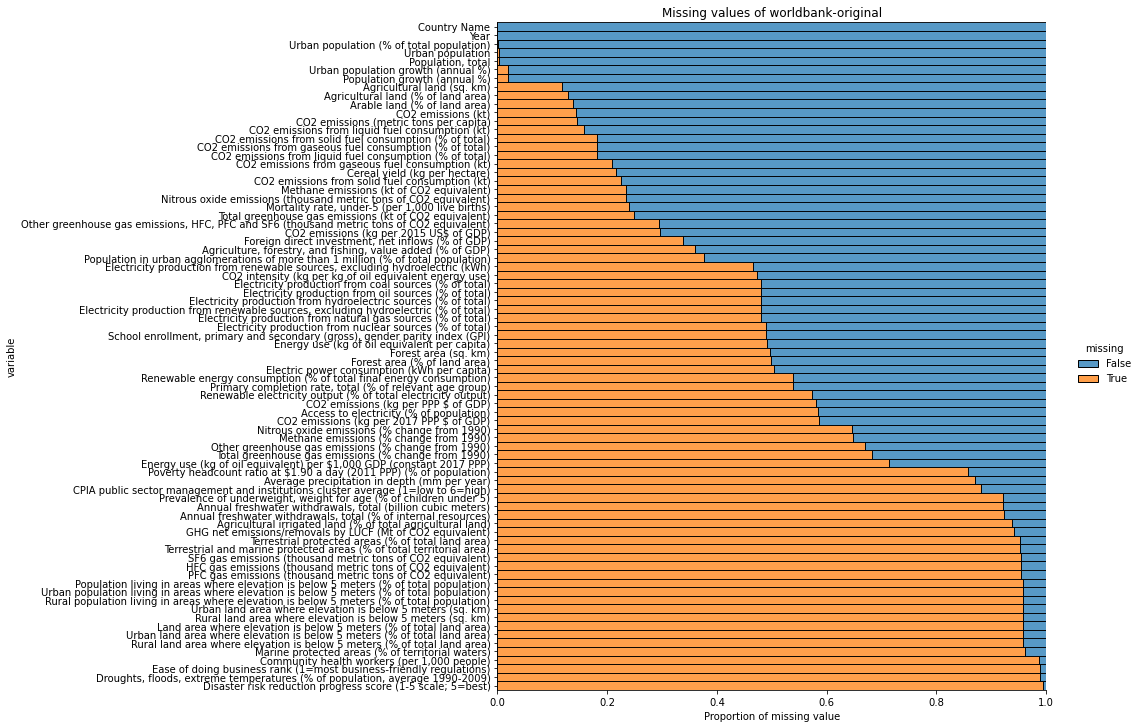

In [72]:
visual_nan(df_original, 'worldbank-original', isSorted=True, savePlot=False)

In [73]:
# function to display the number of missing values and missing ratio
def missing_ratio_summary(df):
    missing = pd.DataFrame(df.isna().sum(), columns=['missing'])
    missing.reset_index(inplace=True)
    missing.rename(columns={'index':'col'}, inplace=True)
    missing['ratio'] = (missing['missing']/len(df)*100).round(2)

    display(missing.sort_values(by=['ratio']))
    
# function to return a list of columns with more than x% of missing values 
def get_X_missing(df, X):
    missing = pd.DataFrame(df.isna().sum(), columns=['missing'])
    missing.reset_index(inplace=True)
    missing.rename(columns={'index':'col'}, inplace=True)
    missing['ratio'] = (missing['missing']/len(df)*100).round(2)
    
    missing_list = missing[missing['ratio'] > X]['col'].tolist()
    return missing_list
    
missing_ratio_summary(df_original)

col  missing  ratio
0                                        Country Name        0   0.00
1                                                Year        0   0.00
2            Urban population (% of total population)        9   0.06
3                                    Urban population       42   0.27
5                                   Population, total       42   0.27
..                                                ...      ...    ...
17   Marine protected areas (% of territorial waters)    14961  96.18
9         Community health workers (per 1,000 people)    15342  98.63
15  Ease of doing business rank (1=most business-f...    15369  98.80
25  Droughts, floods, extreme temperatures (% of p...    15387  98.92
27  Disaster risk reduction progress score (1-5 sc...    15472  99.47

[78 rows x 3 columns]

In [76]:
missing = pd.DataFrame(df_original.isna().sum(), columns=['missing'])
missing.reset_index(inplace=True)
missing.rename(columns={'index':'col'}, inplace=True)
missing['ratio'] = (missing['missing']/len(df_original)*100).round(2)
missing_list = missing[missing['ratio'] > 50]['col'].tolist()

print("A list of columns to be dropped:")
missing_list

A list of columns to be dropped:


['Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)',
 'Prevalence of underweight, weight for age (% of children under 5)',
 'Community health workers (per 1,000 people)',
 'Primary completion rate, total (% of relevant age group)',
 'CPIA public sector management and institutions cluster average (1=low to 6=high)',
 'Ease of doing business rank (1=most business-friendly regulations)',
 'Terrestrial and marine protected areas (% of total territorial area)',
 'Marine protected areas (% of territorial waters)',
 'Terrestrial protected areas (% of total land area)',
 'Annual freshwater withdrawals, total (% of internal resources)',
 'Annual freshwater withdrawals, total (billion cubic meters)',
 'Population living in areas where elevation is below 5 meters (% of total population)',
 'Urban population living in areas where elevation is below 5 meters (% of total population)',
 'Rural population living in areas where elevation is below 5 meters (% of total population)',
 '

In [77]:
print(f"{len(missing_list)} columns will be dropped")

38 columns will be dropped


In [78]:
# Droping the columns
df_original = df_original.drop(columns=missing_list)

### Dropping previous 20 years

Dropping year 1960-1979 from all countries

In [85]:
df_original_filtered = df_original[df_original["Year"] >= 1980] # Year is int
df_original_filtered.Year.unique()

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [89]:
df_original_filtered.reset_index(inplace=True, drop=True)
df_original_filtered

Country Name  Year  Urban population (% of total population)  \
0            Aruba  1980                                    50.472   
1            Aruba  1981                                    50.456   
2            Aruba  1982                                    50.441   
3            Aruba  1983                                    50.426   
4            Aruba  1984                                    50.411   
...            ...   ...                                       ...   
10450     Zimbabwe  2016                                    32.296   
10451     Zimbabwe  2017                                    32.237   
10452     Zimbabwe  2018                                    32.209   
10453     Zimbabwe  2019                                    32.210   
10454     Zimbabwe  2020                                    32.242   

       Urban population  Urban population growth (annual %)  \
0               30332.0                            0.178188   
1               30557.0                            0.739053   
2               30941.0                            1.248837   
3               31372.0                            1.383361   
4               31671.0                            0.948566   
...                 ...                                 ...   
10450         4531238.0                            1.274094   
10451         4589452.0                            1.276544   
10452         4650597.0                            1.323497   
10453         4717307.0                            1.424249   
10454         4792105.0                            1.573169   

       Population, total  Population growth (annual %)  \
0                60097.0                      0.208214   
1                60561.0                      0.769120   
2                61341.0                      1.279734   
3                62213.0                      1.411552   
4                62826.0                      0.980502   
...                  ...                           ...   
10450         14030338.0                      1.549294   
10451         14236599.0                      1.459406   
10452         14438812.0                      1.410382   
10453         14645473.0                      1.421142   
10454         14862927.0                      1.473871   

       Mortality rate, under-5 (per 1,000 live births)  \
0                                                  NaN   
1                                                  NaN   
2                                                  NaN   
3                                                  NaN   
4                                                  NaN   
...                                                ...   
10450                                             59.5   
10451                                             58.2   
10452                                             55.9   
10453                                             54.6   
10454                                              NaN   

       School enrollment, primary and secondary (gross), gender parity index (GPI)  \
0                                                    NaN                             
1                                                    NaN                             
2                                                    NaN                             
3                                                    NaN                             
4                                                    NaN                             
...                                                  ...                             
10450                                                NaN                             
10451                                                NaN                             
10452                                                NaN                             
10453                                                NaN                             
10454                                                NaN            

### Encoding Data (... for feature selection)

In [90]:
# Remove CO2 columns
y_cols = [c for c in df_original_filtered.columns if c.lower()[:13] == 'co2 emissions']
y_cols

['CO2 emissions from solid fuel consumption (% of total)',
 'CO2 emissions from solid fuel consumption (kt)',
 'CO2 emissions (metric tons per capita)',
 'CO2 emissions from liquid fuel consumption (% of total)',
 'CO2 emissions from liquid fuel consumption (kt)',
 'CO2 emissions (kt)',
 'CO2 emissions (kg per 2015 US$ of GDP)',
 'CO2 emissions from gaseous fuel consumption (% of total)',
 'CO2 emissions from gaseous fuel consumption (kt)']

In [91]:
col_list = [col for col in df_original_filtered.columns.tolist() if df_original_filtered[col].dtype.name == "object"]
df_oh = df_original_filtered[col_list]
df = df_original_filtered.drop(col_list, 1)
df_oh = pd.get_dummies(df_oh)
df = pd.concat([df, df_oh], axis=1)
df.head()

Year  Urban population (% of total population)  Urban population  \
0  1980                                    50.472           30332.0   
1  1981                                    50.456           30557.0   
2  1982                                    50.441           30941.0   
3  1983                                    50.426           31372.0   
4  1984                                    50.411           31671.0   

   Urban population growth (annual %)  Population, total  \
0                            0.178188            60097.0   
1                            0.739053            60561.0   
2                            1.248837            61341.0   
3                            1.383361            62213.0   
4                            0.948566            62826.0   

   Population growth (annual %)  \
0                      0.208214   
1                      0.769120   
2                      1.279734   
3                      1.411552   
4                      0.980502   

   Mortality rate, under-5 (per 1,000 live births)  \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   

   School enrollment, primary and secondary (gross), gender parity index (GPI)  \
0                                                NaN                             
1                                                NaN                             
2                                                NaN                             
3                                                NaN                             
4                                                NaN                             

   Agriculture, forestry, and fishing, value added (% of GDP)  \
0                                                NaN            
1                                                NaN            
2                                                NaN            
3                                                NaN            
4                                                NaN            

   Population in urban agglomerations of more than 1 million (% of total population)  \
0                                                NaN                                   
1                                                NaN                                   
2                                                NaN                                   
3                                                NaN                                   
4                                                NaN                                   

   ...  Country Name_Uzbekistan  Country Name_Vanuatu  \
0  ...                        0                     0   
1  ...                        0                     0   
2  ...                        0                     0   
3  ...                        0                     0   
4  ...                        0                     0   

   Country Name_Venezuela, RB  Country Name_Vietnam  \
0                           0                     0   
1                           0                     0   
2                           0                     0   
3                           0                     0   
4                           0                     0   

   Country Name_Virgin Islands (U.S.)  Country Name_West Bank and Gaza  \
0                                   0                                0   
1                                   0                                0   
2                                   0                                0   
3                                   0                                0   
4                                   0                                0   

   Country Name_World  Country Name_Yemen, Rep.  Country Name_Zambia  \
0                   0                         0                    0   
1  

In [92]:
cols = [c for c in df.columns if c.lower()[:13] != 'co2 emissions']
df = df[df.columns.intersection(cols)]
df.head()

Year  Urban population (% of total population)  Urban population  \
0  1980                                    50.472           30332.0   
1  1981                                    50.456           30557.0   
2  1982                                    50.441           30941.0   
3  1983                                    50.426           31372.0   
4  1984                                    50.411           31671.0   

   Urban population growth (annual %)  Population, total  \
0                            0.178188            60097.0   
1                            0.739053            60561.0   
2                            1.248837            61341.0   
3                            1.383361            62213.0   
4                            0.948566            62826.0   

   Population growth (annual %)  \
0                      0.208214   
1                      0.769120   
2                      1.279734   
3                      1.411552   
4                      0.980502   

   Mortality rate, under-5 (per 1,000 live births)  \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   

   School enrollment, primary and secondary (gross), gender parity index (GPI)  \
0                                                NaN                             
1                                                NaN                             
2                                                NaN                             
3                                                NaN                             
4                                                NaN                             

   Agriculture, forestry, and fishing, value added (% of GDP)  \
0                                                NaN            
1                                                NaN            
2                                                NaN            
3                                                NaN            
4                                                NaN            

   Population in urban agglomerations of more than 1 million (% of total population)  \
0                                                NaN                                   
1                                                NaN                                   
2                                                NaN                                   
3                                                NaN                                   
4                                                NaN                                   

   ...  Country Name_Uzbekistan  Country Name_Vanuatu  \
0  ...                        0                     0   
1  ...                        0                     0   
2  ...                        0                     0   
3  ...                        0                     0   
4  ...                        0                     0   

   Country Name_Venezuela, RB  Country Name_Vietnam  \
0                           0                     0   
1                           0                     0   
2                           0                     0   
3                           0                     0   
4                           0                     0   

   Country Name_Virgin Islands (U.S.)  Country Name_West Bank and Gaza  \
0                                   0                                0   
1                                   0                                0   
2                                   0                                0   
3                                   0                                0   
4                                   0                                0   

   Country Name_World  Country Name_Yemen, Rep.  Country Name_Zambia  \
0                   0                         0                    0   
1  

### Feature Selection (Boruta)

In [93]:
rf = RandomForestRegressor(n_jobs=-1, max_depth =64, random_state=1)
feat_selector = BorutaPy(rf, n_estimators="auto", random_state=1)

In [94]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [95]:
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
x_scaled = pd.DataFrame(min_max_scaler.fit_transform(df), index=df.index, columns=df.columns)
df = pd.DataFrame(x_scaled)

In [96]:
# import pandas as pd
# import numpy as np

# def clean_dataset(df):
#     assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
#     df.fillna(0, inplace=True)
#     df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     # return df[indices_to_keep].astype(np.float64)

Fill missing value with median

In [99]:
df.fillna(df.median(), inplace=True)
df.head()

Year  Urban population (% of total population)  Urban population  \
0  0.000                                  0.482255          0.000006   
1  0.025                                  0.482088          0.000006   
2  0.050                                  0.481931          0.000007   
3  0.075                                  0.481774          0.000007   
4  0.100                                  0.481617          0.000007   

   Urban population growth (annual %)  Population, total  \
0                            0.131173           0.000007   
1                            0.141167           0.000007   
2                            0.150251           0.000007   
3                            0.152648           0.000007   
4                            0.144901           0.000007   

   Population growth (annual %)  \
0                      0.287266   
1                      0.310369   
2                      0.331401   
3                      0.336830   
4                      0.319076   

   Mortality rate, under-5 (per 1,000 live births)  \
0                                          0.09839   
1                                          0.09839   
2                                          0.09839   
3                                          0.09839   
4                                          0.09839   

   School enrollment, primary and secondary (gross), gender parity index (GPI)  \
0                                           0.700585                             
1                                           0.700585                             
2                                           0.700585                             
3                                           0.700585                             
4                                           0.700585                             

   Agriculture, forestry, and fishing, value added (% of GDP)  \
0                                           0.134588            
1                                           0.134588            
2                                           0.134588            
3                                           0.134588            
4                                           0.134588            

   Population in urban agglomerations of more than 1 million (% of total population)  \
0                                            0.17158                                   
1                                            0.17158                                   
2                                            0.17158                                   
3                                            0.17158                                   
4                                            0.17158                                   

   ...  Country Name_Uzbekistan  Country Name_Vanuatu  \
0  ...                      0.0                   0.0   
1  ...                      0.0                   0.0   
2  ...                      0.0                   0.0   
3  ...                      0.0                   0.0   
4  ...                      0.0                   0.0   

   Country Name_Venezuela, RB  Country Name_Vietnam  \
0                         0.0                   0.0   
1                         0.0                   0.0   
2                         0.0                   0.0   
3                         0.0                   0.0   
4                         0.0                   0.0   

   Country Name_Virgin Islands (U.S.)  Country Name_West Bank and Gaza  \
0                                 0.0                              0.0   
1                                 0.0                              0.0   
2                                 0.0                              0.0   
3                                 0.0                              0.0   
4                                 0.0                              0.0   

   Country Name_World  Country Name_Yemen, Rep.  Country Name_Zambia  \
0                 0.0                       0.0                  0.0  

In [102]:
y = df_original_filtered['CO2 emissions (metric tons per capita)']
y = y.fillna(y.median())
X = df
colnames = X.columns

In [139]:
feat_selector.fit(X.values, y.values.ravel())

BorutaPy(estimator=RandomForestRegressor(max_depth=64, n_estimators=7,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x173B5850840),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x173B5850840)

In [140]:
boruta_score = ranking(list(map(float, feat_selector.ranking_)), colnames, order=-1)
boruta_score = pd.DataFrame(list(boruta_score.items()), columns=['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score", ascending = False)

In [141]:
print('---------Top 10 for CO2 emissions (metric tons per capita)----------')
display(boruta_score.head(20))

print('---------Bottom 10 for CO2 emissions (metric tons per capita)----------')
boruta_score.tail(10)

---------Top 10 for CO2 emissions (metric tons per capita)----------


Features  Score
0                                                 Year   1.00
11            Methane emissions (kt of CO2 equivalent)   1.00
1             Urban population (% of total population)   1.00
223                                 Country Name_Qatar   1.00
28                  Agricultural land (% of land area)   1.00
15        Energy use (kg of oil equivalent per capita)   1.00
14   CO2 intensity (kg per kg of oil equivalent ene...   1.00
13   Other greenhouse gas emissions, HFC, PFC and S...   1.00
12   Total greenhouse gas emissions (kt of CO2 equi...   1.00
42                                  Country Name_Aruba   1.00
6      Mortality rate, under-5 (per 1,000 live births)   1.00
10   Nitrous oxide emissions (thousand metric tons ...   0.99
8    Agriculture, forestry, and fishing, value adde...   0.99
5                         Population growth (annual %)   0.99
29                          Agricultural land (sq. km)   0.98
4                                    Population, total   0.98
3                   Urban population growth (annual %)   0.97
225                    Country Name_Russian Federation   0.97
25                        Forest area (% of land area)   0.97
24                       Cereal yield (kg per hectare)   0.96

---------Bottom 10 for CO2 emissions (metric tons per capita)----------


Features  Score
202                                 Country Name_Niger   0.03
257                              Country Name_Tanzania   0.03
241                            Country Name_South Asia   0.03
249  Country Name_Sub-Saharan Africa (IDA & IBRD co...   0.02
248                    Country Name_Sub-Saharan Africa   0.02
122                                  Country Name_Guam   0.01
250  Country Name_Sub-Saharan Africa (excluding hig...   0.01
279                 Country Name_Virgin Islands (U.S.)   0.01
280                    Country Name_West Bank and Gaza   0.01
35                         Country Name_American Samoa   0.00

Text(0.5, 1.0, 'Boruta all Features')

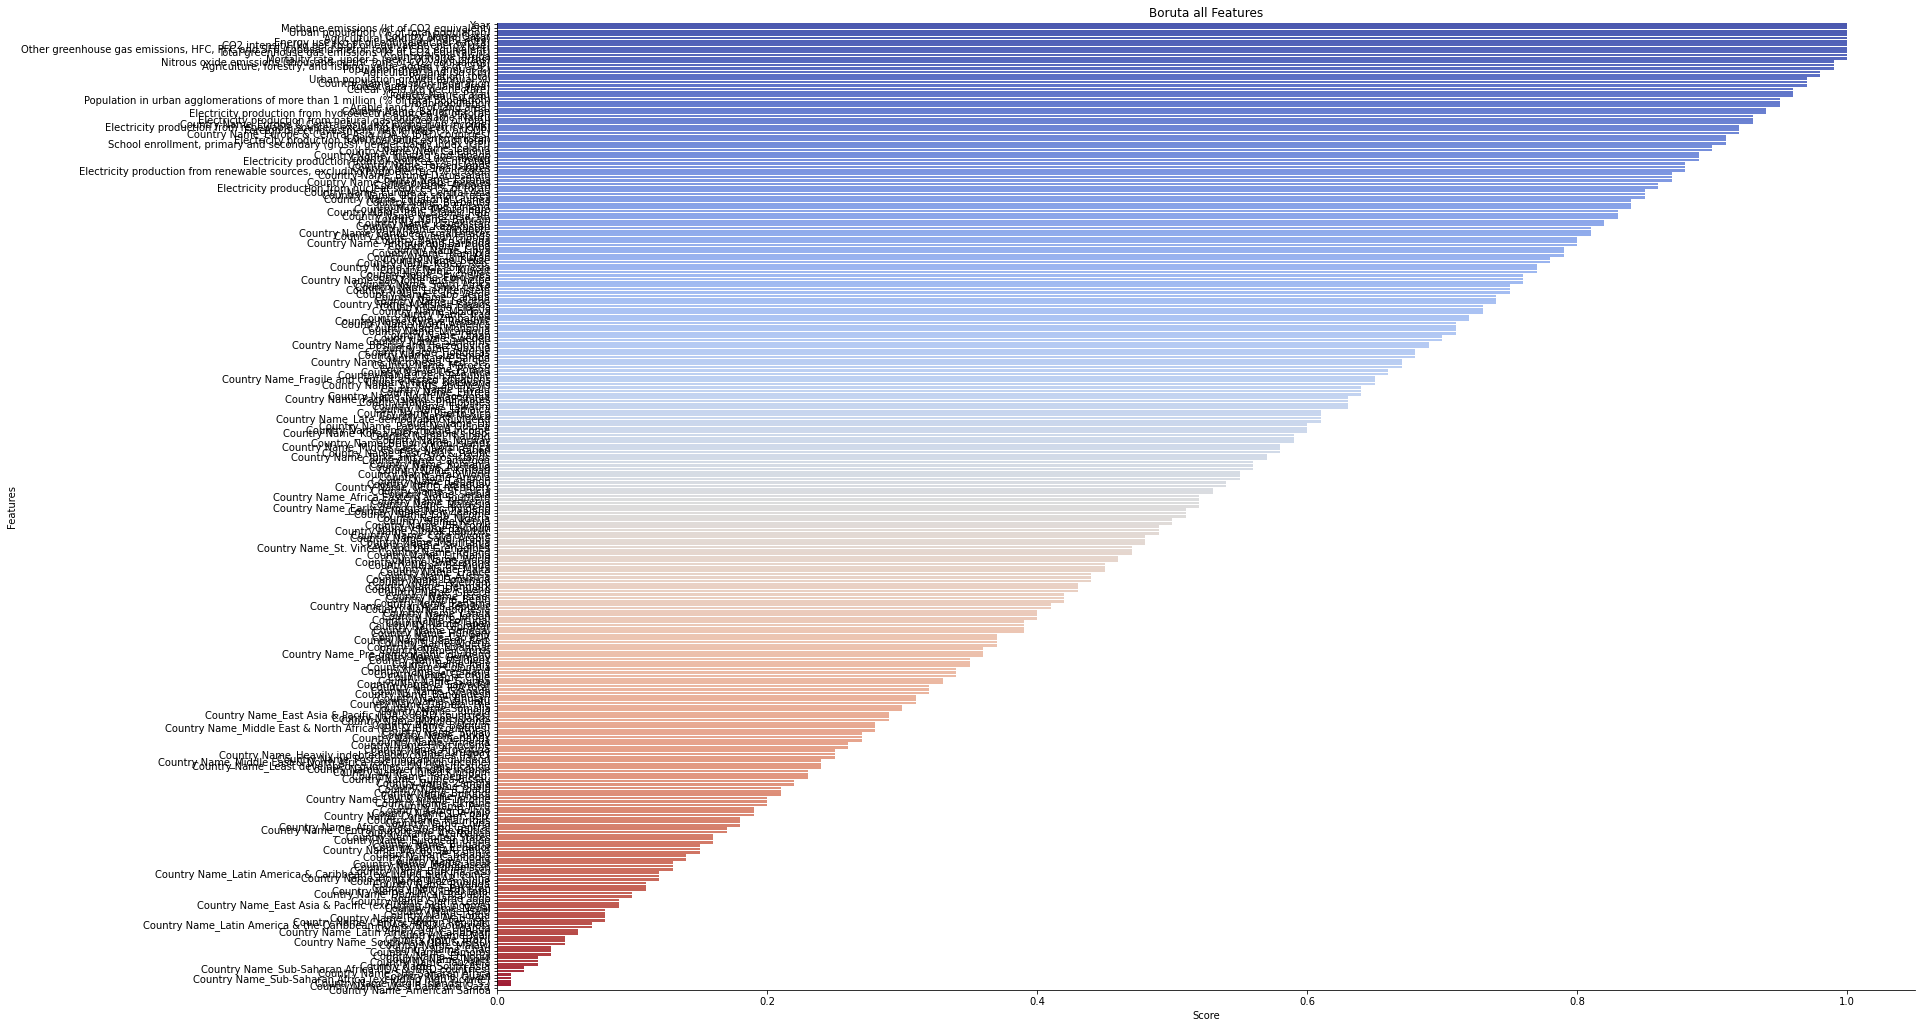

In [142]:
sns_boruta_plot = sns.catplot(x="Score", y="Features", data = boruta_score[:], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("Boruta all Features")

In [143]:
for feat in list(zip(X.columns, feat_selector.ranking_, feat_selector.support_)):
    print('Features: {:<30} Rank： {}, Keep: {}'.format(feat[0],feat[1],feat[2]))

Features: Year                           Rank： 1, Keep: True
Features: Urban population (% of total population) Rank： 1, Keep: True
Features: Urban population               Rank： 15, Keep: False
Features: Urban population growth (annual %) Rank： 9, Keep: False
Features: Population, total              Rank： 7, Keep: False
Features: Population growth (annual %)   Rank： 4, Keep: False
Features: Mortality rate, under-5 (per 1,000 live births) Rank： 2, Keep: False
Features: School enrollment, primary and secondary (gross), gender parity index (GPI) Rank： 26, Keep: False
Features: Agriculture, forestry, and fishing, value added (% of GDP) Rank： 5, Keep: False
Features: Population in urban agglomerations of more than 1 million (% of total population) Rank： 16, Keep: False
Features: Nitrous oxide emissions (thousand metric tons of CO2 equivalent) Rank： 3, Keep: False
Features: Methane emissions (kt of CO2 equivalent) Rank： 2, Keep: False
Features: Total greenhouse gas emissions (kt of CO2 equi

In [144]:
for feat in list(zip(X.columns, feat_selector.ranking_, feat_selector.support_)):
    if feat[2]:
        print('Features: {:<90} Rank： {}, Keep: {}'.format(feat[0],feat[1],feat[2]))

Features: Year                                                                                       Rank： 1, Keep: True
Features: Urban population (% of total population)                                                   Rank： 1, Keep: True
Features: Total greenhouse gas emissions (kt of CO2 equivalent)                                      Rank： 1, Keep: True
Features: Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)  Rank： 1, Keep: True
Features: CO2 intensity (kg per kg of oil equivalent energy use)                                     Rank： 1, Keep: True
Features: Energy use (kg of oil equivalent per capita)                                               Rank： 1, Keep: True
Features: Country Name_Aruba                                                                         Rank： 1, Keep: True


After running feature selection for a few times, we discover that the columns that are highly related to **CO2 emissions (metric tons per capita)** are:

- Year
- Urban population (% of total population)
- Population growth (annual %)
- Total greenhouse gas emissions (kt of CO2 equivalent) <span style="color:green"> (NEW!) </span>
- Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent) <span style="color:green"> (NEW!) </span>
- Methane emissions (kt of CO2 equivalent)
- CO2 intensity (kg per kg of oil equivalent energy use)
- Energy use (kg of oil equivalent per capita)

In [145]:
# a list of columns to keep
col_to_keep = [
    "Year", 
    "CO2 emissions (metric tons per capita)",
    "CO2 emissions (kt)",
    "Urban population (% of total population)", 
    "Population growth (annual %)", 
    "Total greenhouse gas emissions (kt of CO2 equivalent)",
    "Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)",
    "Methane emissions (kt of CO2 equivalent)",
    "CO2 intensity (kg per kg of oil equivalent energy use)",
    "Energy use (kg of oil equivalent per capita)"
]

In [146]:
df_final = df_original_filtered[col_to_keep]
df_final

Year  CO2 emissions (metric tons per capita)  CO2 emissions (kt)  \
0      1980                              174.694594           10498.621   
1      1981                              165.121266            9999.909   
2      1982                              182.270961           11180.683   
3      1983                               92.363156            5746.189   
4      1984                              228.392242           14348.971   
...     ...                                     ...                 ...   
10450  2016                                0.783303           10990.000   
10451  2017                                0.718570           10230.000   
10452  2018                                0.849793           12270.000   
10453  2019                                     NaN                 NaN   
10454  2020                                     NaN                 NaN   

       Urban population (% of total population)  Population growth (annual %)  \
0                                        50.472                      0.208214   
1                                        50.456                      0.769120   
2                                        50.441                      1.279734   
3                                        50.426                      1.411552   
4                                        50.411                      0.980502   
...                                         ...                           ...   
10450                                    32.296                      1.549294   
10451                                    32.237                      1.459406   
10452                                    32.209                      1.410382   
10453                                    32.210                      1.421142   
10454                                    32.242                      1.473871   

       Total greenhouse gas emissions (kt of CO2 equivalent)  \
0                                             424.783771       
1                                             519.001013       
2                                             564.023574       
3                                             530.385687       
4                                             571.038292       
...                                                  ...       
10450                                       29120.000000       
10451                                       28800.000000       
10452                                       31380.000000       
10453                                                NaN       
10454                                                NaN       

       Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)  \
0                                             114.675152                                           
1                                             191.589042                                           
2                                             204.145519                                           
3                                             239.228605                                           
4                                             246.726780                                           
...                                                  ...                                           
10450                                        1587.372070                                           
10451                                                NaN                                           
10452                                                NaN                                           
10453                                                NaN                                           
10454                                                NaN                                           

       Methane emissions (kt of CO2 equivalent)  \
0                                       12.6755   
1                                       12.9370   
2         

### Multivariate Imputation

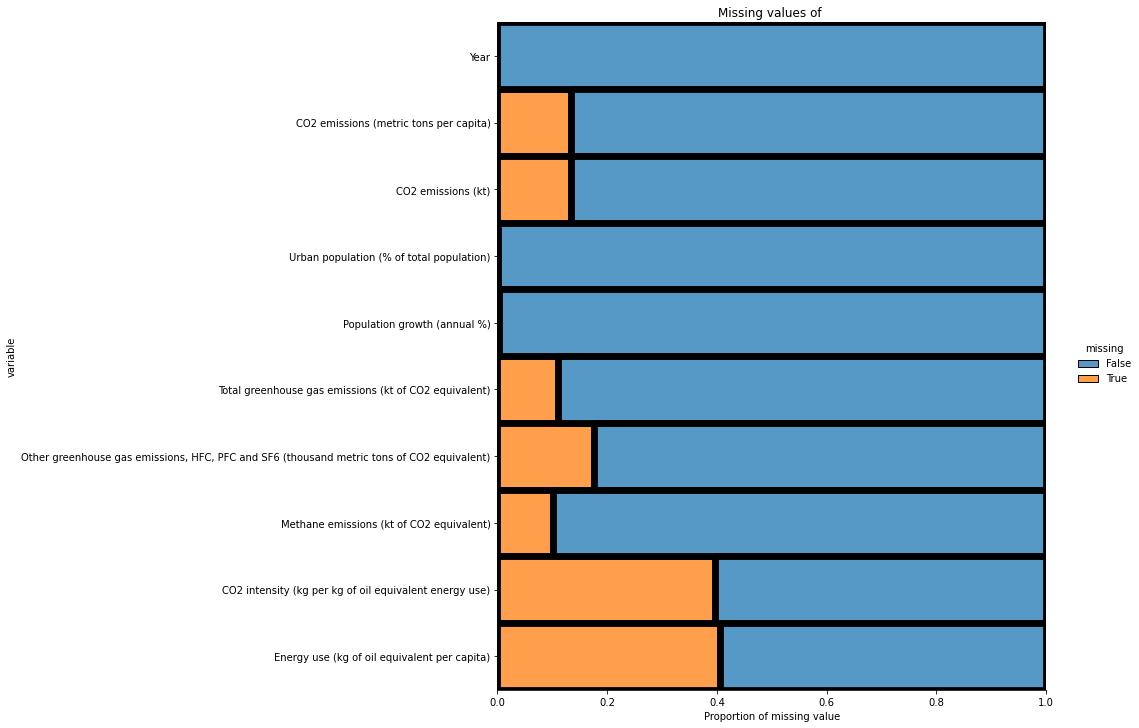

In [147]:
visual_nan(df_final, name="", isSorted=False, savePlot=False)

<AxesSubplot:>

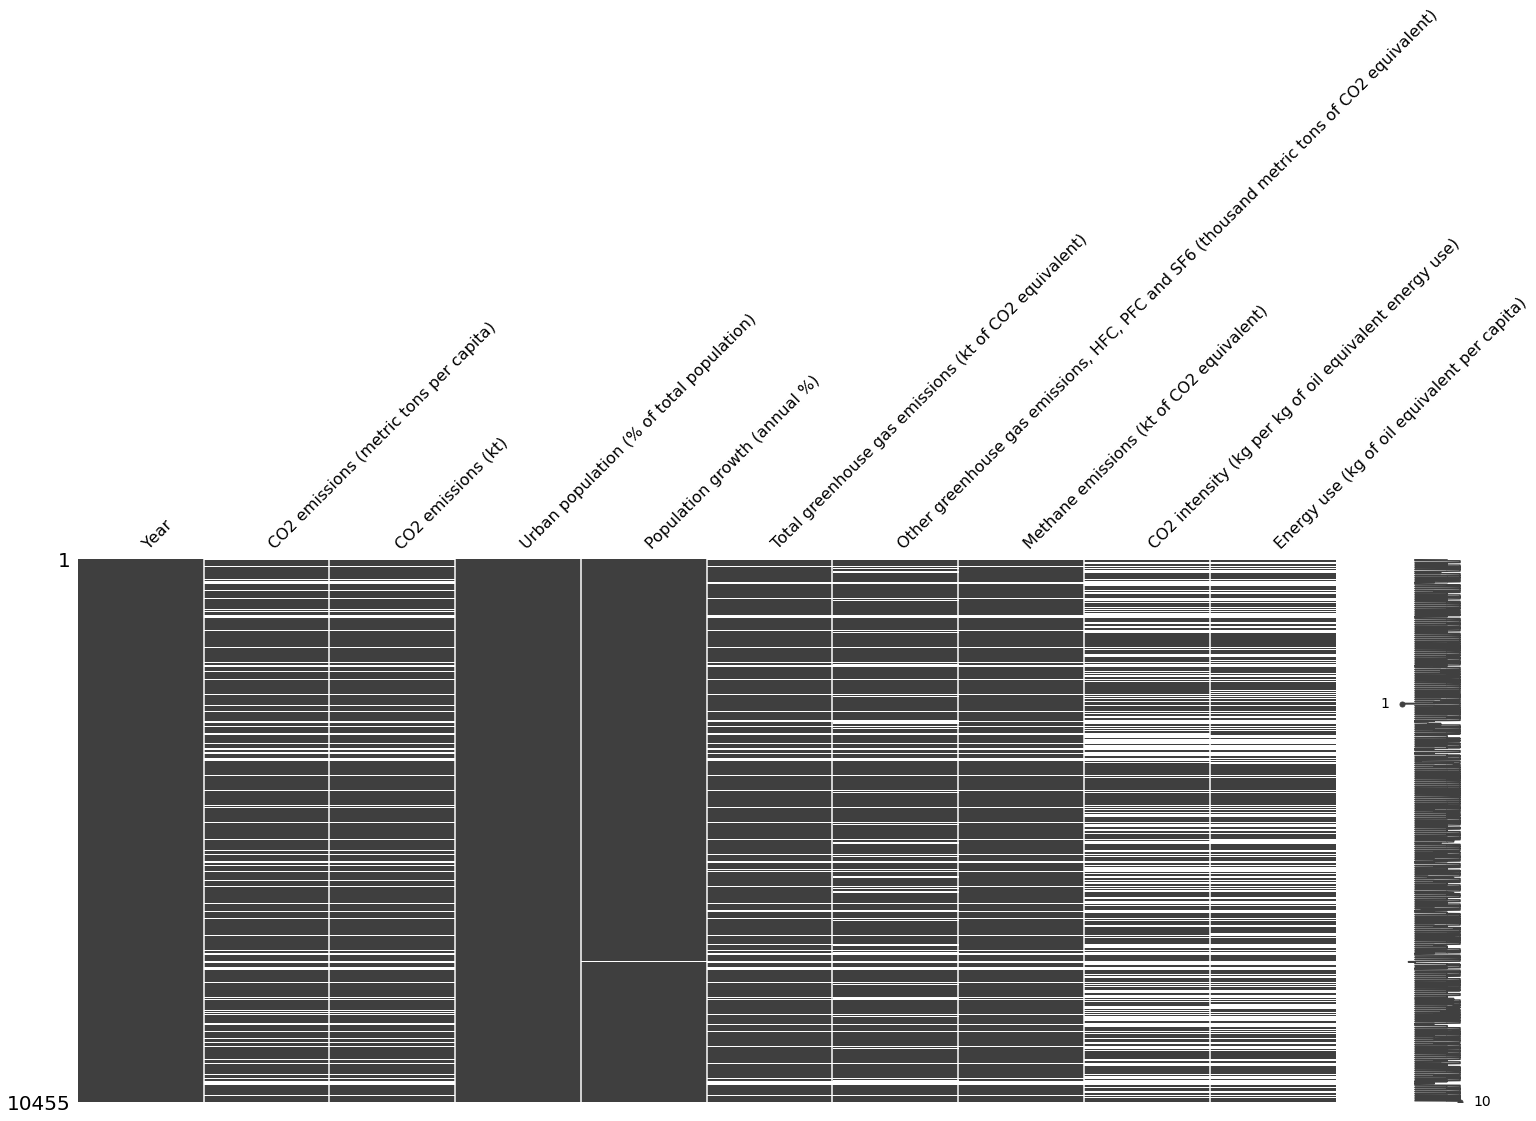

In [148]:
msno.matrix(df_final)

In [149]:
print(df_final.isnull().sum())
len(df_final)

Year                                                                                            0
CO2 emissions (metric tons per capita)                                                       1397
CO2 emissions (kt)                                                                           1394
Urban population (% of total population)                                                        9
Population growth (annual %)                                                                   25
Total greenhouse gas emissions (kt of CO2 equivalent)                                        1156
Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)    1848
Methane emissions (kt of CO2 equivalent)                                                     1056
CO2 intensity (kg per kg of oil equivalent energy use)                                       4139
Energy use (kg of oil equivalent per capita)                                                 4236
dtype: int64


10455

In [150]:
imputer = IterativeImputer(max_iter=20, initial_strategy='median', random_state=2022)
imputer.fit(df_final)

df_imputed_array = imputer.transform(df_final)

In [151]:
df_imputed = pd.DataFrame(df_imputed_array, columns=col_to_keep)
df_imputed['Year'] = df_imputed['Year'].astype('int')
df_imputed['Country Name'] = df_original['Country Name']

cols = df_imputed.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_imputed = df_imputed[cols]
df_imputed

Country Name  Year  CO2 emissions (metric tons per capita)  \
0            Aruba  1980                              174.694594   
1            Aruba  1981                              165.121266   
2            Aruba  1982                              182.270961   
3            Aruba  1983                               92.363156   
4            Aruba  1984                              228.392242   
...            ...   ...                                     ...   
10450        Nepal  2016                                0.783303   
10451        Nepal  2017                                0.718570   
10452        Nepal  2018                                0.849793   
10453        Nepal  2019                                1.044350   
10454        Nepal  2020                                1.009967   

       CO2 emissions (kt)  Urban population (% of total population)  \
0            10498.621000                                    50.472   
1             9999.909000                                    50.456   
2            11180.683000                                    50.441   
3             5746.189000                                    50.426   
4            14348.971000                                    50.411   
...                   ...                                       ...   
10450        10990.000000                                    32.296   
10451        10230.000000                                    32.237   
10452        12270.000000                                    32.209   
10453        22202.653263                                    32.210   
10454        22207.153892                                    32.242   

       Population growth (annual %)  \
0                          0.208214   
1                          0.769120   
2                          1.279734   
3                          1.411552   
4                          0.980502   
...                             ...   
10450                      1.549294   
10451                      1.459406   
10452                      1.410382   
10453                      1.421142   
10454                      1.473871   

       Total greenhouse gas emissions (kt of CO2 equivalent)  \
0                                             424.783771       
1                                             519.001013       
2                                             564.023574       
3                                             530.385687       
4                                             571.038292       
...                                                  ...       
10450                                       29120.000000       
10451                                       28800.000000       
10452                                       31380.000000       
10453                                       83902.692360       
10454                                       83894.818701       

       Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)  \
0                                             114.675152                                           
1                                             191.589042                                           
2                                             204.145519                                           
3                                             239.228605                                           
4                                             246.726780                                           
...                                                  ...                                           
10450                                        1587.372070                                           
10451                                        1266.889816                                           
10452                                        1394.553693                                           
10453                                       23047.297737                                          

### Analysing the imputed data

In [152]:
df_imputed.describe()

Year  CO2 emissions (metric tons per capita)  \
count  10455.000000                            10455.000000   
mean    2000.000000                                4.324286   
std       11.832725                                6.774930   
min     1980.000000                               -0.347210   
25%     1990.000000                                0.749236   
50%     2000.000000                                2.627933   
75%     2010.000000                                5.985056   
max     2020.000000                              266.483562   

       CO2 emissions (kt)  Urban population (% of total population)  \
count        1.045500e+04                              10455.000000   
mean         8.471911e+05                                 53.516498   
std          2.917197e+06                                 23.428964   
min         -2.707582e+04                                  4.339000   
25%          2.240000e+03                                 33.786500   
50%          2.432727e+04                                 52.824000   
75%          1.575450e+05                                 72.615888   
max          3.404105e+07                                100.000000   

       Population growth (annual %)  \
count                  10455.000000   
mean                       1.602138   
std                        1.405863   
min                       -6.766133   
25%                        0.616634   
50%                        1.530234   
75%                        2.540373   
max                       17.512207   

       Total greenhouse gas emissions (kt of CO2 equivalent)  \
count                                       1.045500e+04       
mean                                        1.270182e+06       
std                                         4.072950e+06       
min                                        -2.202420e+03       
25%                                         1.233000e+04       
50%                                         6.743000e+04       
75%                                         2.812050e+05       
max                                         4.587385e+07       

       Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)  \
count                                       1.045500e+04                                           
mean                                        3.816025e+04                                           
std                                         3.734250e+05                                           
min                                        -1.064283e+06                                           
25%                                        -1.610261e+03                                           
50%                                         3.585986e+01                                           
75%                                         7.862724e+03                                           
max                                         6.097786e+06                                           

       Methane emissions (kt of CO2 equivalent)  \
count                              1.045500e+04   
mean                               2.726258e+05   
std                                8.405061e+05   
min                               -1.029579e+04   
25%                                3.380000e+03   
50%                                1.666920e+04   
75%                                6.444500e+04   
max                                8.174420e+06   

       CO2 intensity (kg per kg of oil equivalent energy use)  \
count                                       10455.000000        
mean                                            2.150809        
std                                             1.792490        
min                                             0.000000        
25%                                             1.685609        
50%                                             2.147830        
75%                                             2.558416      

Let's compare the results with the original data

In [154]:
# sliced raw data (benchmark)
df_original_filtered[col_to_keep].describe()

Year  CO2 emissions (metric tons per capita)  \
count  10455.000000                             9058.000000   
mean    2000.000000                                4.348820   
std       11.832725                                7.230377   
min     1980.000000                                0.000000   
25%     1990.000000                                0.595901   
50%     2000.000000                                2.275115   
75%     2010.000000                                6.224190   
max     2020.000000                              266.483562   

       CO2 emissions (kt)  Urban population (% of total population)  \
count        9.061000e+03                              10446.000000   
mean         9.687140e+05                                 53.516319   
std          3.114151e+06                                 23.438916   
min          0.000000e+00                                  4.339000   
25%          1.920000e+03                                 33.773750   
50%          2.132000e+04                                 52.822000   
75%          2.284541e+05                                 72.627000   
max          3.404105e+07                                100.000000   

       Population growth (annual %)  \
count                  10430.000000   
mean                       1.602422   
std                        1.407504   
min                       -6.766133   
25%                        0.613813   
50%                        1.530254   
75%                        2.542483   
max                       17.512207   

       Total greenhouse gas emissions (kt of CO2 equivalent)  \
count                                       9.299000e+03       
mean                                        1.418606e+06       
std                                         4.295579e+06       
min                                         1.554857e+00       
25%                                         9.930000e+03       
50%                                         5.100000e+04       
75%                                         4.625504e+05       
max                                         4.587385e+07       

       Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)  \
count                                       8.607000e+03                                           
mean                                        4.299374e+04                                           
std                                         4.110902e+05                                           
min                                        -1.064283e+06                                           
25%                                        -3.018675e+03                                           
50%                                        -9.126892e+00                                           
75%                                         1.103759e+03                                           
max                                         6.097786e+06                                           

       Methane emissions (kt of CO2 equivalent)  \
count                              9.399000e+03   
mean                               3.006372e+05   
std                                8.820768e+05   
min                                0.000000e+00   
25%                                2.670000e+03   
50%                                1.235480e+04   
75%                                8.354000e+04   
max                                8.174420e+06   

       CO2 intensity (kg per kg of oil equivalent energy use)  \
count                                        6316.000000        
mean                                            2.195555        
std                                             2.266199        
min                                             0.000000        
25%                                             1.565835        
50%                                             2.273189        
75%                                             2.701064      

The imputation results for 

- **CO2 emissions (metric tons per capita)**	
- **CO2 emissions (kt)**
- **Total greenhouse gas emissions (kt of CO2 equivalent)**
- **Methane emissions (kt of CO2 equivalent)**
- **Energy use (kg of oil equivalent per capita)** 

seems to be <span style="color:red">wrong</span> as it they possess records less than 0.

In [183]:
df_imputed_2 = df_imputed.copy()
col_to_correct = ['CO2 emissions (metric tons per capita)',
                  'CO2 emissions (kt)',
                  'Total greenhouse gas emissions (kt of CO2 equivalent)',
                  'Methane emissions (kt of CO2 equivalent)',
                  'Energy use (kg of oil equivalent per capita)']

# display the number of values less than 0 in each target column
values_to_be_correct = []
for col in col_to_correct:
    incorrect_count = df_imputed[f"{col}"][df_imputed[f"{col}"]<0].count()
    values_to_be_correct.append([col, incorrect_count])
    
df_to_be_correct = pd.DataFrame(values_to_be_correct, columns=["column", "number of values less than zeroes"])
display(df_to_be_correct)

# replace values in above mentioned columns that are less than 0 with 0
for col in col_to_correct:
    df_imputed_2[f"{col}"] = np.where(df_imputed_2[f"{col}"] < 0, 0.0, df_imputed_2[f"{col}"])
    
df_imputed_2

column  \
0             CO2 emissions (metric tons per capita)   
1                                 CO2 emissions (kt)   
2  Total greenhouse gas emissions (kt of CO2 equi...   
3           Methane emissions (kt of CO2 equivalent)   
4       Energy use (kg of oil equivalent per capita)   

   number of values less than zeroes  
0                                 10  
1                                153  
2                                  1  
3                                 10  
4                                320

Country Name  Year  CO2 emissions (metric tons per capita)  \
0            Aruba  1980                              174.694594   
1            Aruba  1981                              165.121266   
2            Aruba  1982                              182.270961   
3            Aruba  1983                               92.363156   
4            Aruba  1984                              228.392242   
...            ...   ...                                     ...   
10450        Nepal  2016                                0.783303   
10451        Nepal  2017                                0.718570   
10452        Nepal  2018                                0.849793   
10453        Nepal  2019                                1.044350   
10454        Nepal  2020                                1.009967   

       CO2 emissions (kt)  Urban population (% of total population)  \
0            10498.621000                                    50.472   
1             9999.909000                                    50.456   
2            11180.683000                                    50.441   
3             5746.189000                                    50.426   
4            14348.971000                                    50.411   
...                   ...                                       ...   
10450        10990.000000                                    32.296   
10451        10230.000000                                    32.237   
10452        12270.000000                                    32.209   
10453        22202.653263                                    32.210   
10454        22207.153892                                    32.242   

       Population growth (annual %)  \
0                          0.208214   
1                          0.769120   
2                          1.279734   
3                          1.411552   
4                          0.980502   
...                             ...   
10450                      1.549294   
10451                      1.459406   
10452                      1.410382   
10453                      1.421142   
10454                      1.473871   

       Total greenhouse gas emissions (kt of CO2 equivalent)  \
0                                             424.783771       
1                                             519.001013       
2                                             564.023574       
3                                             530.385687       
4                                             571.038292       
...                                                  ...       
10450                                       29120.000000       
10451                                       28800.000000       
10452                                       31380.000000       
10453                                       83902.692360       
10454                                       83894.818701       

       Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)  \
0                                             114.675152                                           
1                                             191.589042                                           
2                                             204.145519                                           
3                                             239.228605                                           
4                                             246.726780                                           
...                                                  ...                                           
10450                                        1587.372070                                           
10451                                        1266.889816                                           
10452                                        1394.553693                                           
10453                                       23047.297737                                          

In [166]:
df_imputed_2.describe()

Year  CO2 emissions (metric tons per capita)  \
count  10455.000000                            10455.000000   
mean    2000.000000                                4.324454   
std       11.832725                                6.774820   
min     1980.000000                                0.000000   
25%     1990.000000                                0.749236   
50%     2000.000000                                2.627933   
75%     2010.000000                                5.985056   
max     2020.000000                              266.483562   

       CO2 emissions (kt)  Urban population (% of total population)  \
count        1.045500e+04                              10455.000000   
mean         8.473830e+05                                 53.516498   
std          2.917141e+06                                 23.428964   
min          0.000000e+00                                  4.339000   
25%          2.240000e+03                                 33.786500   
50%          2.432727e+04                                 52.824000   
75%          1.575450e+05                                 72.615888   
max          3.404105e+07                                100.000000   

       Population growth (annual %)  \
count                  10455.000000   
mean                       1.602138   
std                        1.405863   
min                       -6.766133   
25%                        0.616634   
50%                        1.530234   
75%                        2.540373   
max                       17.512207   

       Total greenhouse gas emissions (kt of CO2 equivalent)  \
count                                       1.045500e+04       
mean                                        1.270182e+06       
std                                         4.072949e+06       
min                                         0.000000e+00       
25%                                         1.233000e+04       
50%                                         6.743000e+04       
75%                                         2.812050e+05       
max                                         4.587385e+07       

       Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)  \
count                                       1.045500e+04                                           
mean                                        3.816025e+04                                           
std                                         3.734250e+05                                           
min                                        -1.064283e+06                                           
25%                                        -1.610261e+03                                           
50%                                         3.585986e+01                                           
75%                                         7.862724e+03                                           
max                                         6.097786e+06                                           

       Methane emissions (kt of CO2 equivalent)  \
count                              1.045500e+04   
mean                               2.726300e+05   
std                                8.405047e+05   
min                                0.000000e+00   
25%                                3.380000e+03   
50%                                1.666920e+04   
75%                                6.444500e+04   
max                                8.174420e+06   

       CO2 intensity (kg per kg of oil equivalent energy use)  \
count                                       10455.000000        
mean                                            2.150809        
std                                             1.792490        
min                                             0.000000        
25%                                             1.685609        
50%                                             2.147830        
75%                                             2.558416      

In [40]:
# # from sklearn.impute import SimpleImputer

# # simple_imp = SimpleImputer(strategy='median')
# # simple_imp.fit(df_final)

# knn_imp = KNNImputer(n_neighbors=3)
# simple_imp.fit(df_final)

# df_imputed_array_3 = simple_imp.transform(df_final)

In [41]:
# df_imputed_3 = pd.DataFrame(df_imputed_array_3, columns=col_to_keep)
# df_imputed_3['Year'] = df_imputed_3['Year'].astype('int')
# df_imputed_3['Country Name'] = df_original['Country Name']

# cols = df_imputed_3.columns.tolist()
# cols = cols[-1:] + cols[:-1]
# df_imputed_3 = df_imputed_3[cols]
# df_imputed_3

In [184]:
print(df_imputed_2.isnull().sum())
len(df_imputed_2)

Country Name                                                                                 0
Year                                                                                         0
CO2 emissions (metric tons per capita)                                                       0
CO2 emissions (kt)                                                                           0
Urban population (% of total population)                                                     0
Population growth (annual %)                                                                 0
Total greenhouse gas emissions (kt of CO2 equivalent)                                        0
Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)    0
Methane emissions (kt of CO2 equivalent)                                                     0
CO2 intensity (kg per kg of oil equivalent energy use)                                       0
Energy use (kg of oil equivalent per capita)      

10455

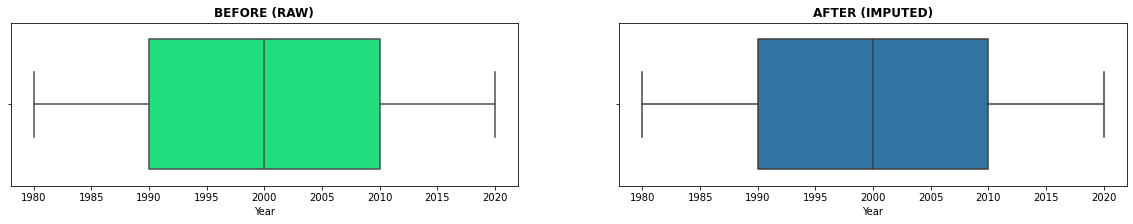

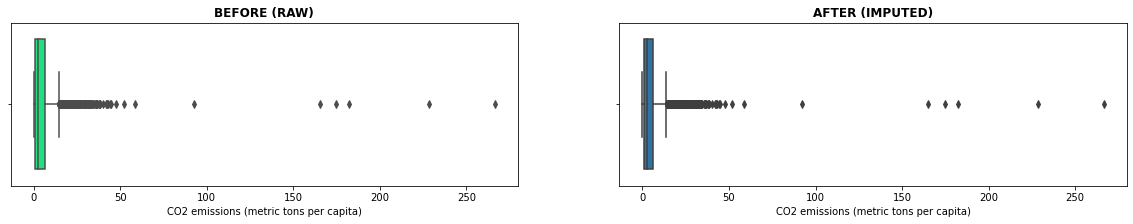

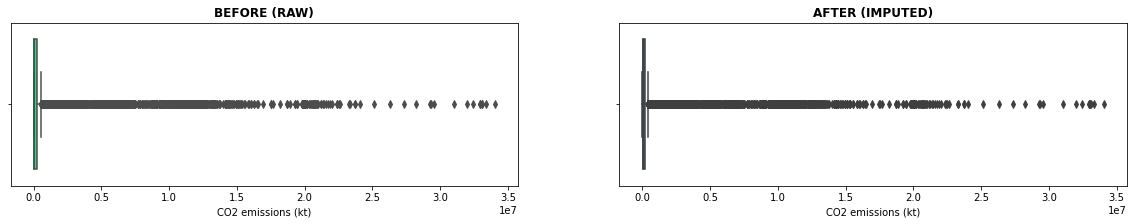

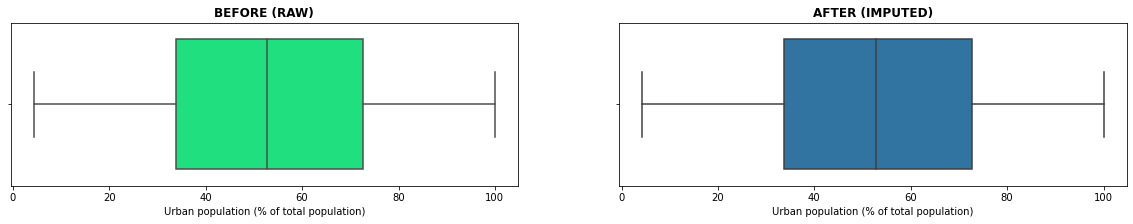

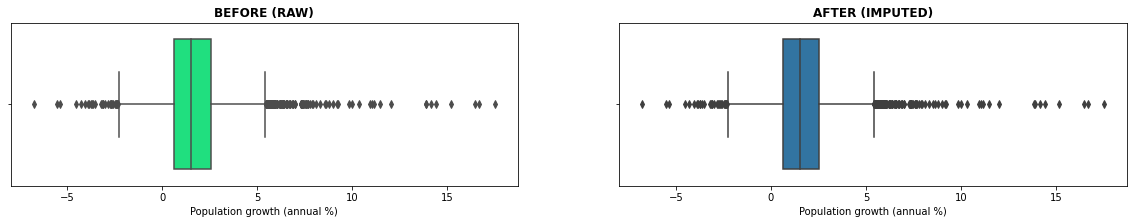

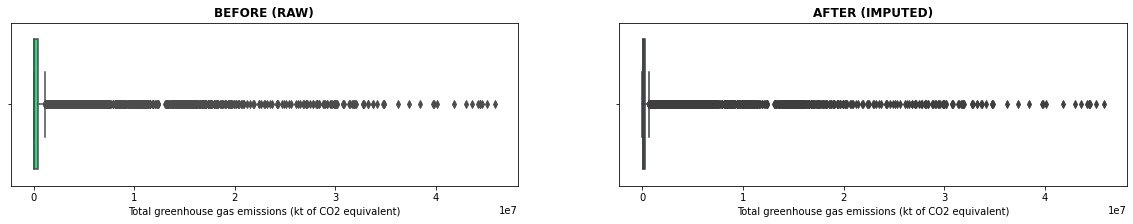

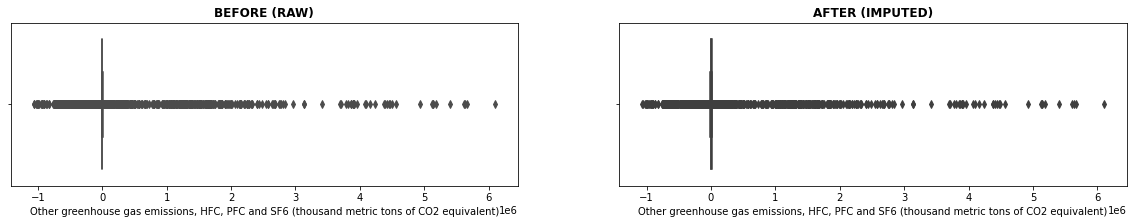

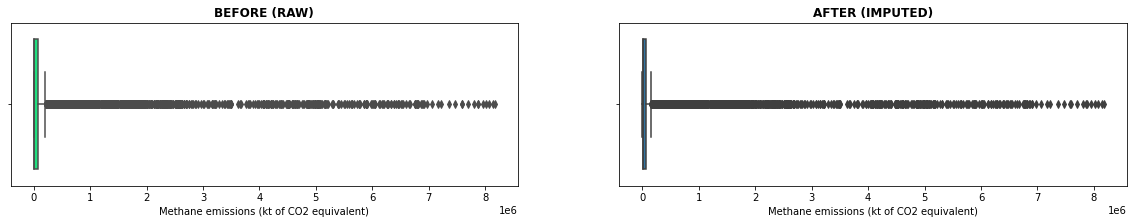

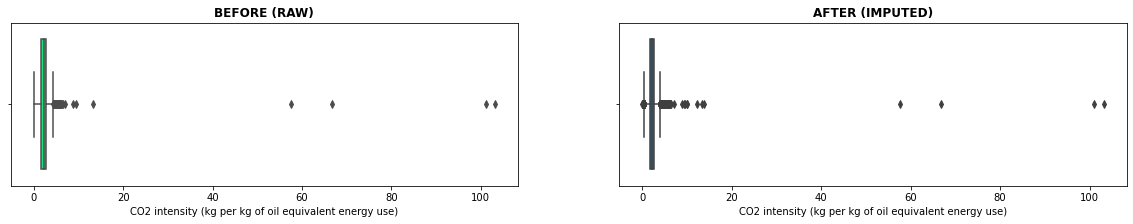

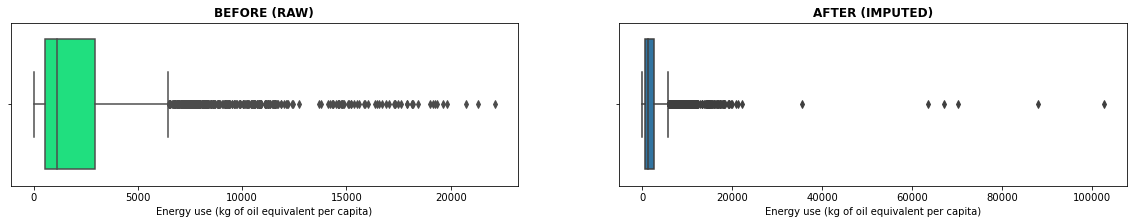

In [186]:
# comparing data before and after imputed
for col in col_to_keep:
    plt.figure(figsize=(20, 3))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df_final[f"{col}"], color="springgreen")
    plt.title("BEFORE (RAW)", fontweight="bold")
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_imputed_2[f"{col}"])
    plt.title("AFTER (IMPUTED)", fontweight="bold")
    
    plt.show()

In [187]:
# view this in vscode
for col in col_to_keep:
    fig = px.box(df_imputed_2, x=f"{col}")
    fig.show()

In [188]:
# view this in vscode too
for col in col_to_keep:
    fig = px.box(df_final, x=f"{col}")
    fig.update_traces(marker_color="green")
    fig.show()

In [ ]:
# def multivariate_imputation(df, iso_code, country):
    
#     N = 20
#     df_train = df.iloc[:-N] 
#     df_test = df[-N:] # last N years

#     print(f'Training years: {df_train.shape[0]}')
#     print(f'Test years: {df_test.shape[0]}')
    
#     visual_nan(df_train.shape[0], name="", isSorted=False, savePlot=True)
    
#     imp = IterativeImputer(max_iter=10, random_state=2022)
#     imp.fit(df_train.iloc[:, :49]) # exclude last column

#     df_predict_array = imp.transform(df_test.iloc[:, :49])

#     columns = df.columns.tolist()[:49]
#     df_predict = pd.DataFrame(df_predict_array, columns=columns) # array to df
    
#     df_predict['iso_code'] = iso_code
#     df_predict['country'] = country
#     df_predict['year'] = df_test['Year'].to_list() # predicted years

#     return df_predict

# def multivariate_imputation(df):
    
#     imp = IterativeImputer(max_iter=10, random_state=2022)
#     imp.fit(df.iloc[:, 1:]) # exclude last column

#     df_predict_array = imp.transform(df[:, 1:])

#     columns = df[:, 1:].columns.tolist()
#     df_predict = pd.DataFrame(df_predict_array, columns=columns) # array to df

#     return df_predict

In [ ]:
# df = multivariate_imputation(df_original)
# df.head()

In [189]:
df_imputed_2.to_csv('output/dataset_worldbank_imputed.csv', index=False)
print('Completed!')

Completed!
